Here we define the way we'll be training the large (100 site) TFIM

In [1]:
import tensorflow as tf 
import tensorflow_addons as tfa
import numpy as np 
import matplotlib.pyplot as plt 
import itertools
import copy
from typing import *
from TransformerWF import *
import cirq
from numpy import linalg as LA
from entanglement_tools import *
from scramble_spins import scramble
import logging
import json

C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [4]:
def tfim_E_loc(J, g, configuration, decoder, scrambled=False, use_stoquastic=True):
    """
    configuration should have shape
    
    config_length
    
    Note during training we throw away the phase term. 
    This is because the tfim is stoquastic
    
    we need to consider the same state, and the state 
    with each site flipped.
    
    return the real and imaginary parts of E_loc
    
    if scramble, then un-scramble states before evaluating their ELOC values
    """
    
    if scrambled:
        """
        This means that the transformer lives in 'scrambled space'
        we need to de-scramble to evaluate energy properties
        """
        scrambled_configuration = configuration.copy()
        
        configuration = scramble(
            states=configuration.copy(),
            invert=True,
            reps=4,
            seed=0,
        )
    
    batch_size = configuration.shape[0]
    config_length = configuration.shape[1]
    flip_off_diags = np.ones((config_length, config_length)) - 2*np.identity(config_length)
    
    flipped_states = np.einsum("bl,lh->bhl", 2*configuration - 1, flip_off_diags)
    flipped_states = ((flipped_states+1)/2).astype(np.int32)
    
    """
    include z contributions
    """
    signs = (2*configuration-1).astype(np.int32)
    E_loc_real_part = J*np.sum(signs[..., 1:]*signs[..., :-1], -1)
    E_loc_imag_part = 0.0
    
    """
    include off-diagonal contributions
    
    flipped_states has shape 
    (batch_size, length, length)
    
    """
    
    reshaped_flipped_states = np.reshape(
        flipped_states, 
        (-1, config_length)
    )
    
    """
    now evaluate wavefunctions
    """
    
    if scrambled:
        """
        we need to map the flipped states back to 'scrambled space'
        they will then be fed into the transformer
        """
        scrambled_reshaped_flipped_states = scramble(
            states=reshaped_flipped_states,
            invert=False,
            reps=4,
            seed=0,
        )
    
        log_probs, total_phases = decoder.evaluate_state(
            scrambled_configuration,
        )

        flipped_log_probs, flipped_total_phases = decoder.evaluate_state(
            scrambled_reshaped_flipped_states,
        )
        
    else:
        log_probs, total_phases = decoder.evaluate_state(
            configuration,
        )

        flipped_log_probs, flipped_total_phases = decoder.evaluate_state(
            reshaped_flipped_states,
        )
    
    flipped_total_phases = tf.reshape(flipped_total_phases, (batch_size, -1))
    flipped_log_probs = tf.reshape(flipped_log_probs, (batch_size, -1))
    
    ratio_mags = tf.math.exp(
        (1/2)*(flipped_log_probs - log_probs[..., None])
    )
    
    """
    Below, we effectively assert that phases for all states are 0
    """
    if use_stoquastic:
        ratio_real_part = ratio_mags
        ratio_imag_part = tf.zeros_like(ratio_mags)
    else:
        ratio_real_part = ratio_mags*tf.math.cos(-total_phases[..., None] + flipped_total_phases)
        ratio_imag_part = ratio_mags*tf.math.sin(-total_phases[..., None] + flipped_total_phases)
    
    E_loc_real_part += g*tf.reduce_sum(ratio_real_part, -1)
    E_loc_imag_part = g*tf.reduce_sum(ratio_imag_part, -1)
    
    assert E_loc_real_part.shape[0]==batch_size
    assert E_loc_imag_part.shape[0]==batch_size
    
    return E_loc_real_part, E_loc_imag_part

In [5]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=400, final_step = 1000, minimum_step_size = 10**-8):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        self.final_step = final_step
        self.minimum_step_size = minimum_step_size
        
        self.initial_slope = tf.math.rsqrt(self.d_model*self.warmup_steps)/self.warmup_steps
        
        self.c = tf.math.rsqrt(self.d_model*self.warmup_steps)
        
        self.rate = -(final_step - warmup_steps)/np.log(minimum_step_size)
        
    def __call__(self, step):
        
        if step<self.warmup_steps:
            return self.initial_slope*step
        
        return self.c*np.exp(-(step-self.warmup_steps)/self.rate)

# sanity checking

_Any_ change to $E_{loc}$ should be followed by a check to ensure that the resulting trained state matches the GS on a small system size.

step 0 to 1 mean: -10.420893
step 1 to 2 mean: -10.474077
step 2 to 4 mean: -10.217583
step 4 to 6 mean: -10.773079
step 6 to 8 mean: -11.236605
step 8 to 12 mean: -11.3774
step 12 to 18 mean: -11.689896
step 18 to 26 mean: -11.458229
step 26 to 37 mean: -11.737637
step 37 to 54 mean: -11.687328
step 54 to 78 mean: -11.798024
step 78 to 112 mean: -12.06929
step 112 to 162 mean: -12.334062
step 162 to 233 mean: -12.351584
step 233 to 335 mean: -12.374771
step 335 to 483 mean: -12.37939
step 483 to 695 mean: -12.380965
comparing to exact diagonalization
overlap: 0.9999178460582672


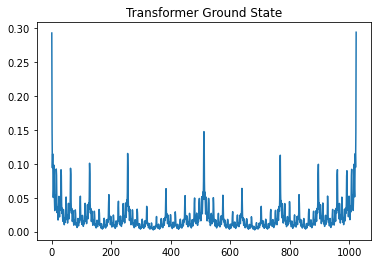

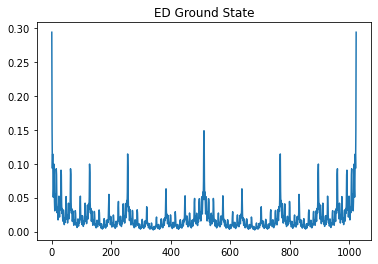

In [7]:
"""
Do we want to check this all works on a small system size
"""
check_eloc = True

if check_eloc:
    
    def local_energy_function(states, decoder):
        return tfim_E_loc(
            J=-1, 
            g=-1, 
            configuration=states, 
            decoder=decoder, 
            scrambled=False
        )
    
    check_indices = [0]+[int(index) for index in np.logspace(0, 3, 20)]
    
    embedding_dimension=15
    
    test_learning_rate = CustomSchedule(
        d_model=embedding_dimension, 
        warmup_steps=250, 
        final_step = 1000, 
        minimum_step_size = 0.001,
    )

    test_optimizer = tf.keras.optimizers.Adam(
        test_learning_rate, 
        beta_1=0.9, 
        beta_2=0.98, 
        epsilon=1e-9,
    )
    
    test_sequence_length=10+1

    test_decoder=TransformerDecoder( 
        num_heads=2, 
        key_dim=embedding_dimension, 
        value_dim=embedding_dimension, 
        embedding_dim=embedding_dimension, 
        dictionary_size=2,
        decoding_reps=2, 
        width=15, 
        depth=2,
        name=None,
        sequence_length=test_sequence_length,
        dropout=0,
        attention_dropout=0,
        final_temperature=1,
    )
    
    initial_training_reps = 1000
    Ns=50
    
    test_real_energies = []
    test_imag_energies = []

    for current_rep in range(initial_training_reps):

        derivatives, (e_real, e_imag) = test_decoder.evaluate_gradients(Ns, local_energy_function, reps=1)

        test_optimizer.apply_gradients(zip(derivatives, test_decoder.trainable_weights))

        test_real_energies.append(e_real)
        test_imag_energies.append(e_imag)
        
        if current_rep in check_indices and current_rep>0:
            position = check_indices.index(current_rep)
            prev = check_indices[position-1]
            print(f"step {prev} to {current_rep} mean:", np.mean(test_real_energies[prev:current_rep]))
    
    """
    compute overlap with exact ground state
    """
    
    print("comparing to exact diagonalization")

    tfim_ham = cirq.PauliSum()

    for i in range(9):
        tfim_ham+= -1*cirq.Z(cirq.LineQubit(i))*cirq.Z(cirq.LineQubit(i+1))

    for i in range(10):
        tfim_ham+= -1*cirq.X(cirq.LineQubit(i))
    
    ham_mat = tfim_ham.matrix()

    ws, vs = LA.eigh(ham_mat)

    gs = get_explicit_transformer_state(
        test_decoder,
        qubit_num=10,
        assert_real=True,
    )

    overlap = np.abs(np.sum(gs*vs[:, 0]))
    
    print(f"overlap: {overlap}")
    
    plt.plot(np.abs(gs))
    plt.title("Transformer Ground State")
    plt.show()
    
    plt.plot(np.abs(vs[:, 0]))
    plt.title("ED Ground State")
    plt.show()
    
    # free up any space this may have taken
    #del test_decoder

In [11]:
s, _, _ = test_decoder.autoregressive_sampling(np.zeros((100, 1)))

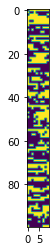

In [13]:
plt.imshow(s)

In [14]:
ws

array([-12.38149   , -12.08256963, -11.49140626, ...,  11.49140626,
        12.08256963,  12.38149   ])

In [15]:
test_real_energies[-1]

-12.390272

# training the model

In [7]:
embedding_dimension=15
sequence_length=100+1
"""
params = {
    "num_heads": 2, 
    "key_dim": embedding_dimension, 
    "value_dim": embedding_dimension, 
    "embedding_dim": embedding_dimension, 
    "dictionary_size": 2,
    "decoding_reps": 2, 
    "width": None, 
    "depth": 2,
    "sequence_length": sequence_length,
}

"""
params = {
    "num_heads": 1, 
    "key_dim": embedding_dimension, 
    "value_dim": embedding_dimension, 
    "embedding_dim": embedding_dimension, 
    "dictionary_size": 2,
    "decoding_reps": 1, 
    "width": None, 
    "depth": 2,
    "sequence_length": sequence_length,
}

In [8]:
"""
We choose a random seed for this initialization
"""
seed = 1

In [16]:
name = f"modified_training_length_100_tfim_seed_{seed}_extremely_simple_model"

with open(f"params_{name}.json", "w") as outfile:
    json.dump(params, outfile)

NameError: name 'seed' is not defined

In [10]:
tf.random.set_seed(seed=seed)

decoder=TransformerDecoder(
    **params
)

In [11]:
print("number of params: ", np.sum([np.prod(array.shape) for array in decoder.trainable_weights]))

number of params:  1099


In [12]:
def local_energy_function(states, decoder):
    return tfim_E_loc(
        J=-1, 
        g=-1, 
        configuration=states, 
        decoder=decoder, 
        scrambled=False
    )

In [13]:
learning_rate = CustomSchedule(
    d_model=embedding_dimension, 
    warmup_steps=400, 
    final_step = 2000, 
    minimum_step_size = 10**-4,
)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

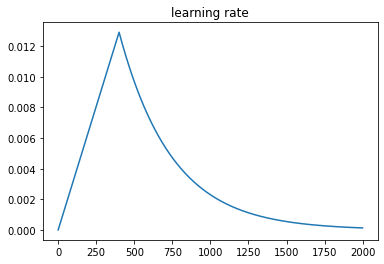

In [14]:
plt.plot([learning_rate(float(n)) for n in range(2000)])
plt.title("learning rate")
plt.show()

In [15]:
real_energies = []
imag_energies = []

In [16]:
Ns=50

for idx in range(learning_rate.final_step):
    
    derivatives, (e_real, e_imag) = decoder.evaluate_gradients(Ns, local_energy_function)
    
    optimizer.apply_gradients(zip(derivatives, decoder.trainable_weights))
    
    real_energies.append(e_real)
    imag_energies.append(e_imag)
    
    if idx%5==0 and idx>0:
        print(f"step {idx-5} to {idx} mean:", np.mean(real_energies[-5:]))
    
    if idx%50==0:
        np.save(f"{name}.npy", np.array(list(zip(real_energies, imag_energies)), dtype=np.complex128))
        decoder.save_weights(name)

np.save(f"{name}.npy", np.array(list(zip(real_energies, imag_energies)), dtype=np.complex128))
decoder.save_weights(name)

step 0 to 5 mean: -118.58437
step 5 to 10 mean: -119.29299
step 10 to 15 mean: -119.70325
step 15 to 20 mean: -120.314064
step 20 to 25 mean: -120.8073
step 25 to 30 mean: -121.93803
step 30 to 35 mean: -122.372025
step 35 to 40 mean: -123.01894
step 40 to 45 mean: -123.760544
step 45 to 50 mean: -123.597046
step 50 to 55 mean: -123.70878
step 55 to 60 mean: -124.007614
step 60 to 65 mean: -123.86056
step 65 to 70 mean: -124.28108
step 70 to 75 mean: -124.28994
step 75 to 80 mean: -124.76802
step 80 to 85 mean: -124.83649
step 85 to 90 mean: -125.11473
step 90 to 95 mean: -125.26982
step 95 to 100 mean: -125.36228
step 100 to 105 mean: -125.617355
step 105 to 110 mean: -125.813866
step 110 to 115 mean: -125.92883
step 115 to 120 mean: -126.02352
step 120 to 125 mean: -126.033104
step 125 to 130 mean: -126.15653
step 130 to 135 mean: -126.06948
step 135 to 140 mean: -126.27693
step 140 to 145 mean: -126.15188
step 145 to 150 mean: -126.24827
step 150 to 155 mean: -126.2828
step 155 to 1

step 1230 to 1235 mean: -126.83069
step 1235 to 1240 mean: -126.82262
step 1240 to 1245 mean: -126.84465
step 1245 to 1250 mean: -126.785995
step 1250 to 1255 mean: -126.83687
step 1255 to 1260 mean: -126.84324
step 1260 to 1265 mean: -126.853676
step 1265 to 1270 mean: -126.868454
step 1270 to 1275 mean: -126.86664
step 1275 to 1280 mean: -126.88013
step 1280 to 1285 mean: -126.88771
step 1285 to 1290 mean: -126.9026
step 1290 to 1295 mean: -126.90875
step 1295 to 1300 mean: -126.866066
step 1300 to 1305 mean: -126.891884
step 1305 to 1310 mean: -126.88103
step 1310 to 1315 mean: -126.88417
step 1315 to 1320 mean: -126.908554
step 1320 to 1325 mean: -126.85929
step 1325 to 1330 mean: -126.90723
step 1330 to 1335 mean: -126.85903
step 1335 to 1340 mean: -126.910355
step 1340 to 1345 mean: -126.791504
step 1345 to 1350 mean: -126.82855
step 1350 to 1355 mean: -126.856064
step 1355 to 1360 mean: -126.9095
step 1360 to 1365 mean: -126.88753
step 1365 to 1370 mean: -126.85929
step 1370 to 

In [17]:
energy = []
for rep in range(10):
    initial_states = np.zeros((50, 1))
    
    samples, log_probs, phases = decoder.autoregressive_sampling(
        initial_states
    )
    
    er, ei = local_energy_function(samples, decoder)
    
    energy.append(er)

In [18]:
np.mean(energy), np.std(energy, ddof=1)

(-126.841255, 0.486457)

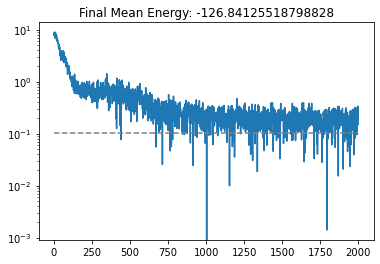

In [19]:
plt.plot(np.array(real_energies)-np.min(np.array(real_energies)))
plt.hlines(-126.96187673950975 -np.min(np.array(real_energies)),0, len(real_energies) , linestyle='dashed', color='grey')
plt.title(f"Final Mean Energy: {np.mean(energy)}")
plt.yscale('log')